In [1]:
import rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

import torch
from hydra import compose, initialize
from topobenchmarkx.data.preprocessor import PreProcessor
from topobenchmarkx.data.loaders import HypergraphLoader
from topobenchmarkx.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)

%load_ext autoreload
%autoreload 2

initialize(config_path="../configs", job_name="job")


/tmp/ipykernel_3379302/3649000859.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="job")


hydra.initialize()

### Loade the data and calculate the group homophily

In [2]:
cfg = compose(config_name="run.yaml", overrides=["dataset=hypergraph/coauthorship_cora","transforms=data_manipulations/group_homophily" ], return_hydra_config=True)
loader = HypergraphLoader(cfg.dataset.loader.parameters)
dataset, dataset_dir = loader.load()

# Apply transform

transform_config = {"group_homophily" :
    {
    '_target_': 'topobenchmarkx.transforms.data_transform.DataTransform',
    'transform_name': 'GroupCombinatorialHomophily',
    'transform_type': 'data manipulation',
    'top_k': 10,
    }
}
processed_dataset = PreProcessor(dataset, dataset_dir, transform_config)
data = processed_dataset.data

Download complete.
number of nodes:2708, feature dimension: 1433
number of hyperedges: 1072
Final num_hyperedges 1392
Final num_nodes 2708
Final num_class 7


Extracting /home/lev/projects/TopoBenchmark/datasets/hypergraph/coauthorship/coauthorship_cora/raw/coauthorship_cora.zip
Processing...
Done!
Processing...
/home/lev/projects/TopoBenchmark/topobenchmarkx/transforms/data_manipulations/group_homophily.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  he_cardinalities_k = torch.tensor(H_k.sum(0), dtype=torch.long)
Done!
/home/lev/miniconda3/envs/tbx/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.war

### Define plotting function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

colors = np.array([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#d6616b', '#d1e5f0', '#e7ba52', '#d6616b', '#ad494a',
    '#8c6d31', '#e7969c', '#7b4173', '#aec7e8', '#ff9896',
    '#98df8a', '#d62728', '#ffbb78', '#1f77b4', '#ff7f0e',
    '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#c5b0d5', '#c49c94', '#f7b6d2',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#d6616b', '#d1e5f0', '#e7ba52', '#d6616b', '#ad494a',
    '#8c6d31', '#e7969c', '#7b4173', '#aec7e8', '#ff9896',
    '#98df8a', '#d62728', '#ffbb78', '#1f77b4', '#ff7f0e',
    '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#c5b0d5', '#c49c94', '#f7b6d2'
])  


def normalised_bias(D, B):
    out = torch.zeros(D.shape)
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if D[i,j] >= B[i,j]:
                out[i,j] = (D[i,j] - B[i,j]) / (1 - B[i,j])
            else:
                out[i,j] = (D[i,j] - B[i,j]) / B[i,j]
    return out


def make_plot(Dt, Bt, max_k, number_of_he, plot_type, ax, plot_tyitle=False):
    settings = {
      'font.family': 'serif',
      'text.latex.preamble': '\\renewcommand{\\rmdefault}{ptm}\\renewcommand{\\sfdefault}{phv}',
      'figure.figsize': (5.5, 3.399186938124422),
      'figure.constrained_layout.use': True,
      'figure.autolayout': False,
      'font.size': 16,
      'axes.labelsize': 24,
      'legend.fontsize': 24,
      'xtick.labelsize': 24,
      'ytick.labelsize': 24,
      'axes.titlesize': 24}
    with plt.rc_context(settings):
        if plot_type == 'normalised':
            h_t = normalised_bias(Dt, Bt)
        
        elif plot_type == 'affinity/baseline':
            h_t = Dt/Bt

        elif plot_type == 'affinity':
            h_t = Dt
            
        else:
            raise ValueError('plot_type must be one of: normalised, affinity/baseline, affinity')
        

        if max_k <= 20:    
        # Plot h_t lines with different colors corresponting to each row
            for i in range(h_t.shape[0]):
                ax.plot(h_t[i],  '-o', markersize=8, color=colors[i], linewidth=2)

        else:
            x_values_to_visualize = []
            # Visualise only non-zero values, x indices have to correspont to position of non zero values
            for i in range(h_t.shape[0]):
                # Get non-zero values
                if plot_type in ['affinity', 'affinity/baseline']:
                    non_zero = np.where(h_t[i, :] > 1e-6)[0]
                    #print(non_zero)
                elif plot_type == 'normalised': 
                    # do not take the ones which are equal to 0
                    
                    non_zero = np.where((h_t[i, :] > -0.99) & (h_t[i, :] != 0))[0]

                # Plot non-zero values and make sure when several values have same y value they are not plotted on top of each other
                ax.plot(non_zero + 1, h_t[i, non_zero], '-o', markersize=4, color=colors[i])

                # Add x values to the list of x values to visualise
                x_values_to_visualize.extend(list(set(list(non_zero + 1))))
        
        
        # Manually put axis x values and five size of the ticks
        if max_k <= 20:
            ax.set_xticks(range(h_t.shape[1]), [str(i) for i in range(1, h_t.shape[1]+1)])
        else:
            ax.set_xticks(x_values_to_visualize, [str(i) for i in x_values_to_visualize])
            
        # Size of the ticks
        ax.tick_params(axis='x', which='major')
    
        # Add title and labels
        if plot_tyitle:
            ax.set_title(f'{max_k}-uniform hypergraph, number of hyperedges: {number_of_he}')
        else:
            pass    
        # Add grid to the plot
        ax.grid()
        if plot_type == 'normalised':
            ax.set_ylabel('Normalised bias', fontsize=20)
            # Put a line perpendicular axis x in values 1, make it thin and black
            ax.axhline(y=0, color='k', linestyle='--', linewidth=2)
            # Make y scale be between 0 and 1
            ax.set_ylim(-1.1, 1.1)
            #plt.ylim(bottom=-1.2)

        elif plot_type == 'affinity/baseline':
            ax.set_ylabel('Affinity/Baseline', fontsize=20 )
            # Make y axis logarithmic with 10 as base
            # Make y axis logarithmic but manually
            ax.set_yscale('symlog')
            
            # Put a line perpendicular axis x in values 1, make it thin and black
            ax.axhline(y=1, color='k', linestyle='--', linewidth=2)
            ax.set_yticks([0, 1])
            ax.set_ylim(bottom=-0.5)

        elif plot_type == 'affinity':
            ax.set_ylabel('Affinity', fontsize=20)
            ax.set_ylim(-0.1, 1.1)
        else:
            raise ValueError('plot_type must be one of: normalised, affinity-t, affinity')
        ax.grid()
    return ax

### Plotting

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


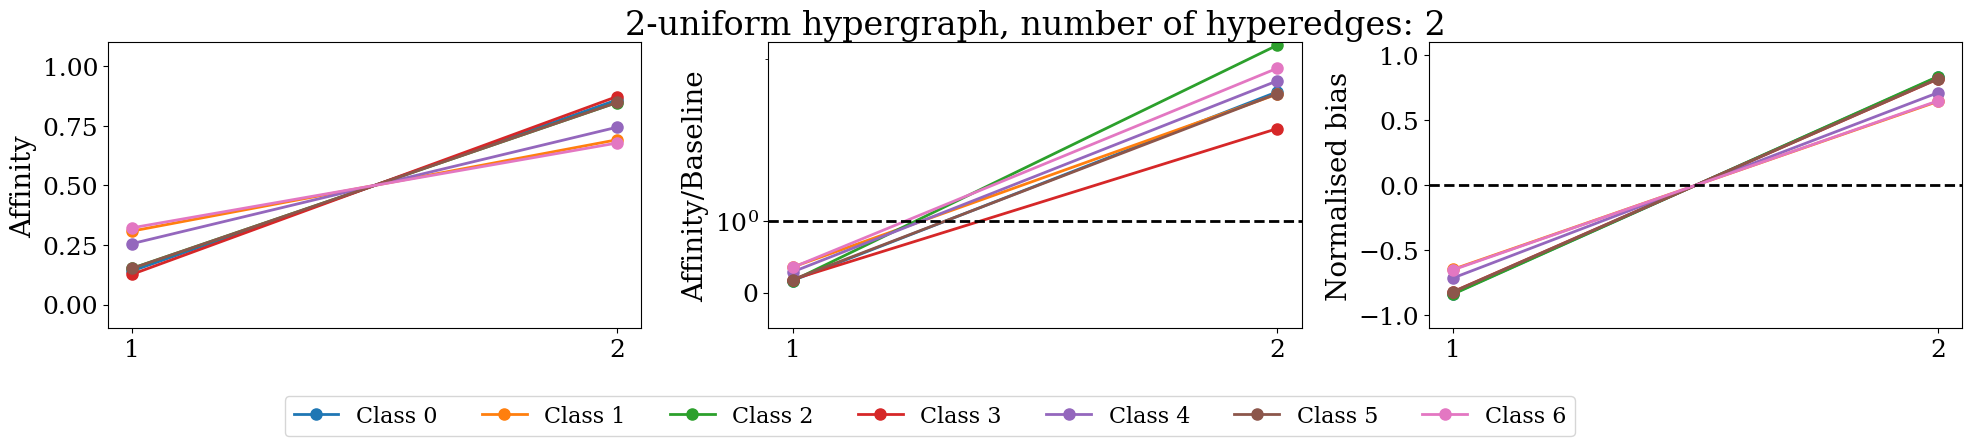

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


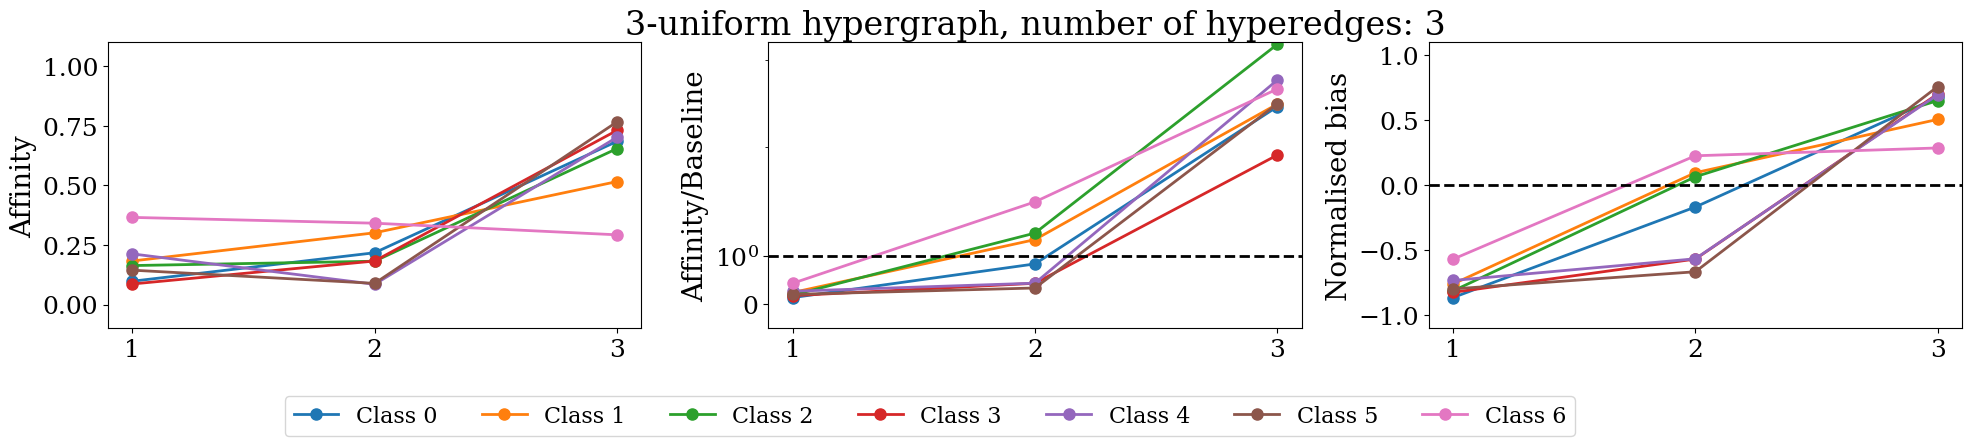

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


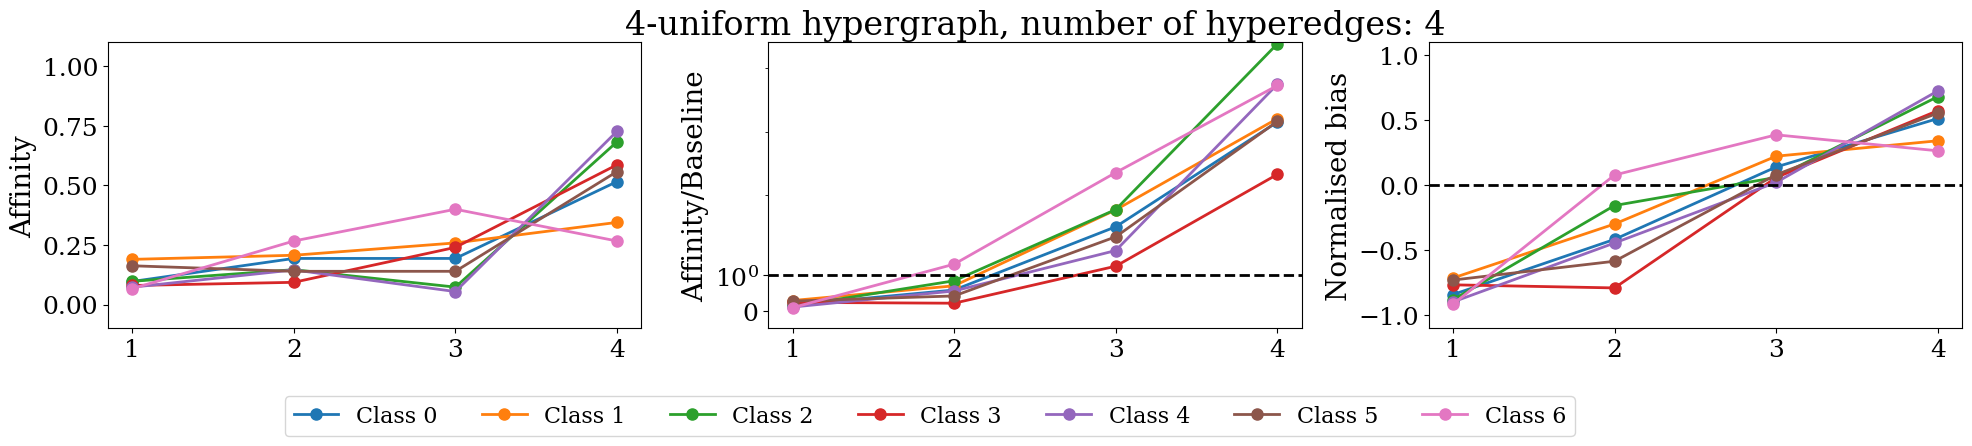

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


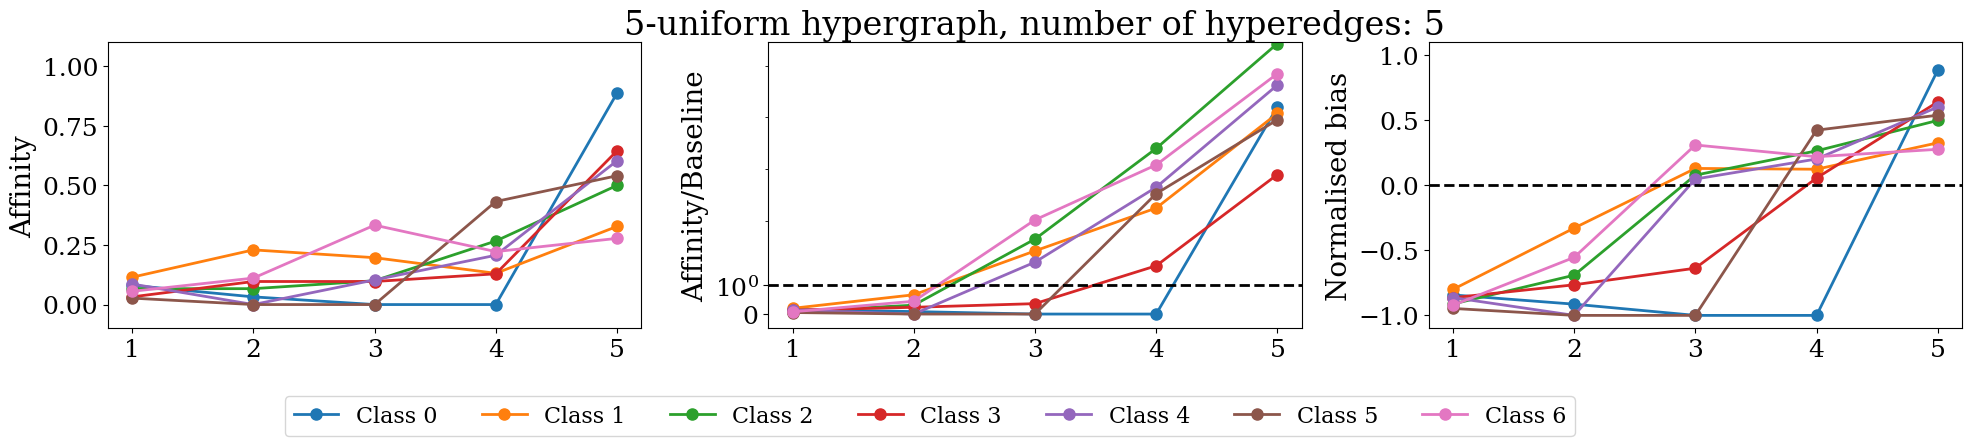

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


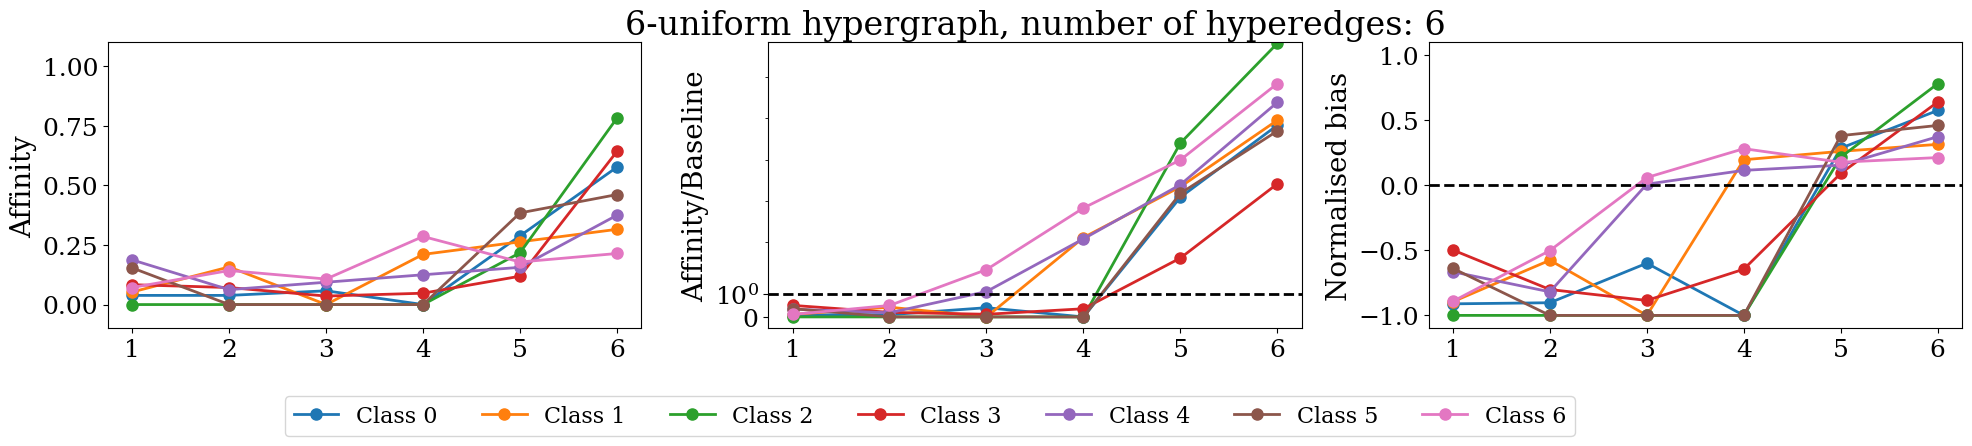

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


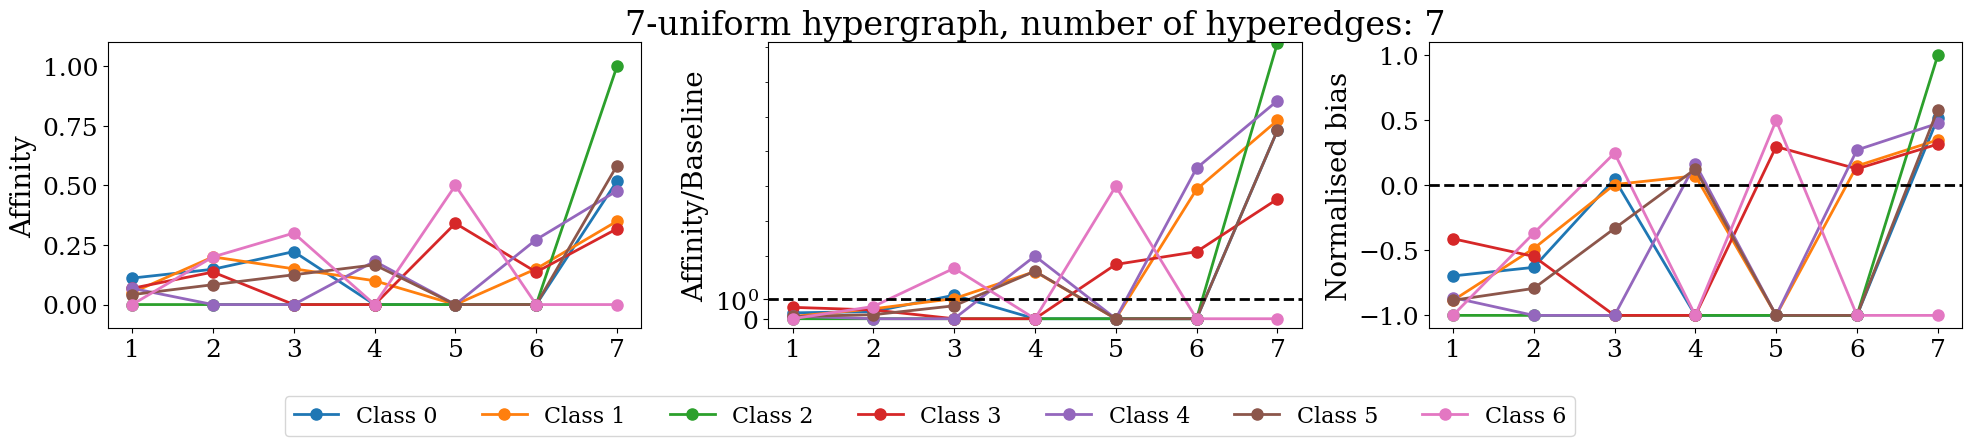

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


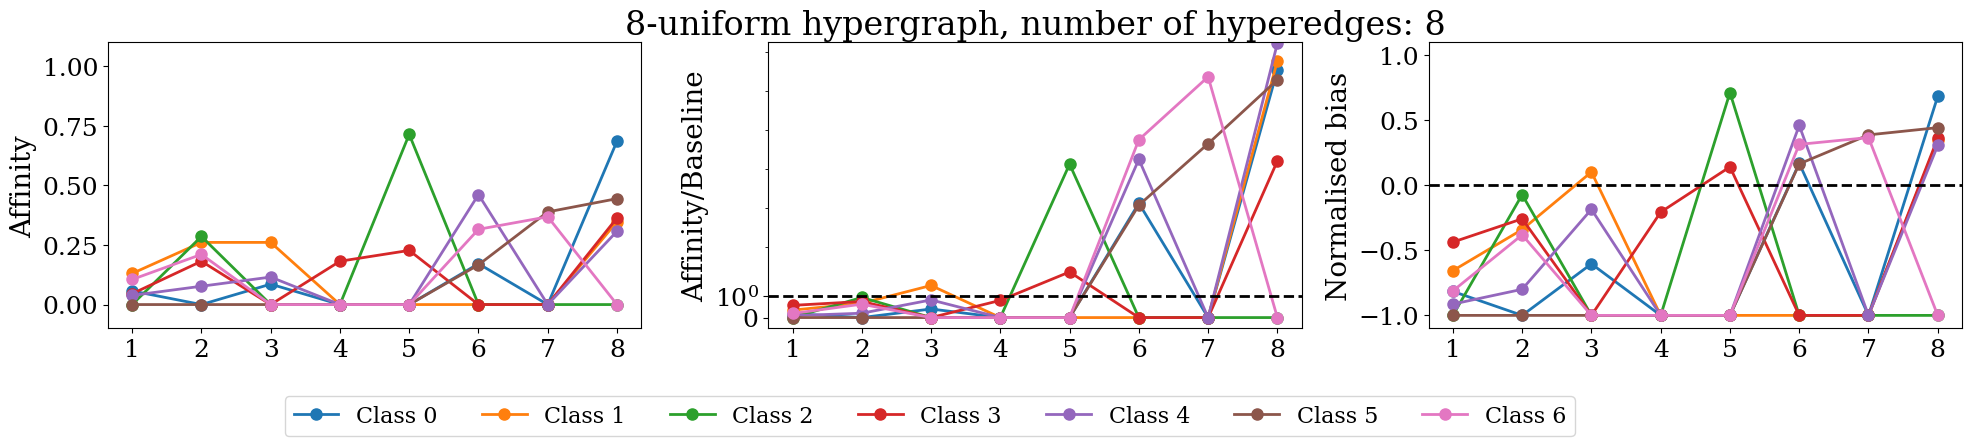

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


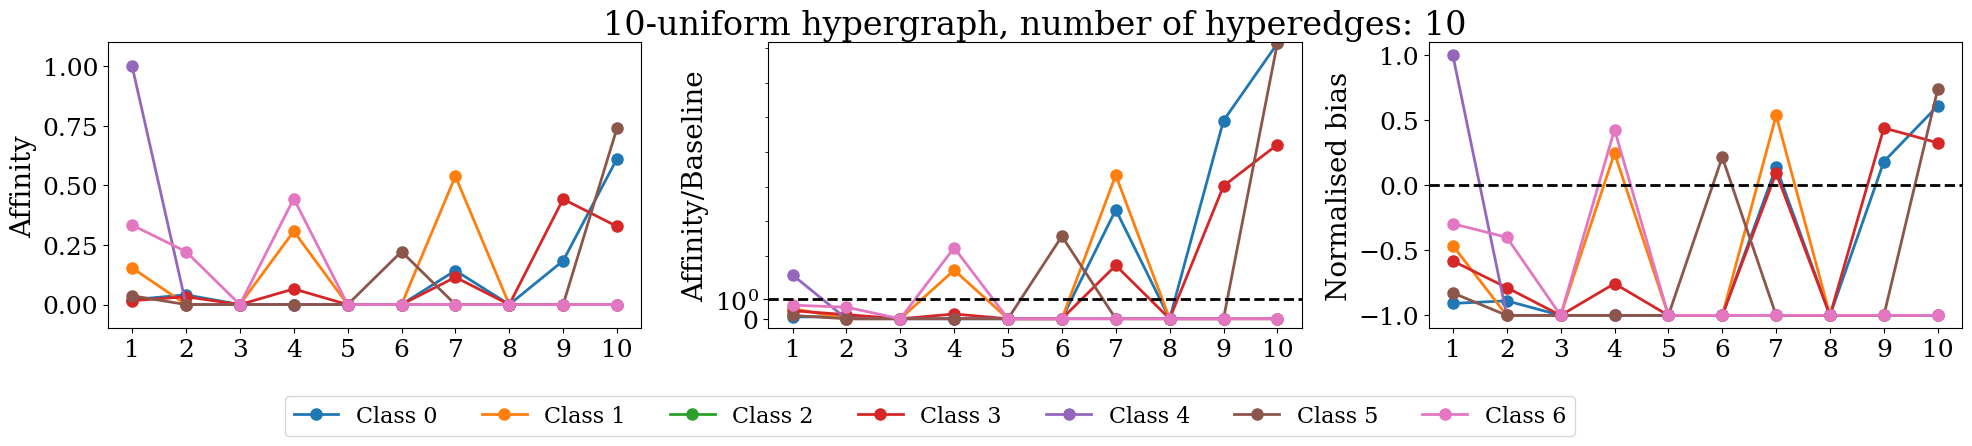

/tmp/ipykernel_3379302/352802501.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


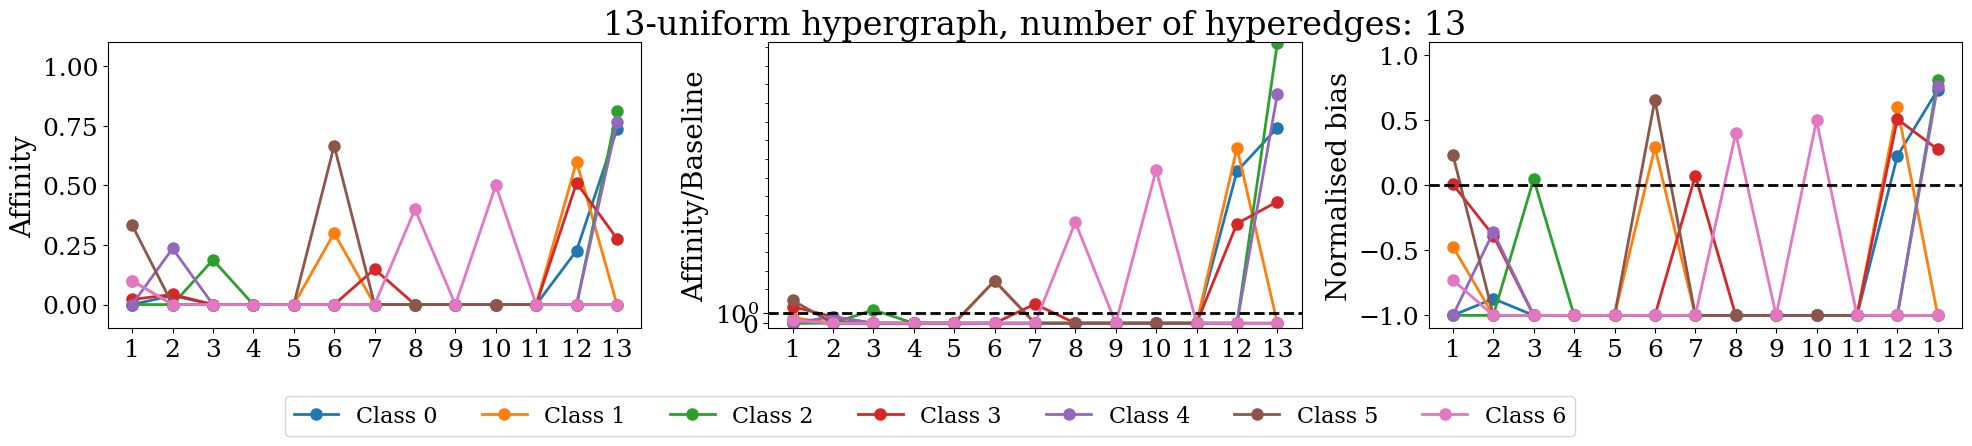

In [8]:
unique_labels = torch.unique(data.y).numpy()
figures = []
for key in data.group_combinatorial_homophily.keys():
    max_k = int(key.strip('he_card='))
    Dt, Bt, number_of_he = data.group_combinatorial_homophily[key]['Dt'], data.group_combinatorial_homophily[key]['Bt'], data.group_combinatorial_homophily[key]['num_hyperedges']

    settings = {
                'font.family': 'serif',
                'text.latex.preamble': '\\renewcommand{\\rmdefault}{ptm}\\renewcommand{\\sfdefault}{phv}',
                'figure.figsize': (20, 4),
                'figure.constrained_layout.use': True,
                'figure.autolayout': False,
                'font.size': 16,
                'axes.labelsize': 18,
                'legend.fontsize': 24,
                'xtick.labelsize': 18,
                'ytick.labelsize': 18,
                'axes.titlesize': 18}
    with plt.rc_context(settings):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        figures.append(make_plot(Dt, Bt, max_k, max_k, ax=ax1, plot_type='affinity'))
        figures.append(make_plot(Dt, Bt, max_k, max_k, ax=ax2, plot_type='affinity/baseline', plot_tyitle=True))
        figures.append(make_plot(Dt, Bt, max_k, max_k, ax=ax3, plot_type='normalised'))
        f.tight_layout()

        if Dt.shape[0]>4 and Dt.shape[0]<= 20:
            f.legend(['Class {}'.format(i) for i in range(len(unique_labels))], fontsize=16,
                    ncol=Dt.shape[0], 
                    bbox_to_anchor=(0.8, .0))
        
        
        elif len(unique_labels)> 20:
            pass
        else:
            f.legend(['Class {}'.format(i) for i in range(len(unique_labels))], fontsize=16,
                    ncol=Dt.shape[0], 
                    bbox_to_anchor=(0.65, .0))
        plt.show()
